# Lung Cancer Detection using revoscalepy and microsoftml

In [2]:
import pandas as pd
import sys

from revoscalepy import RxSqlServerData, rx_data_step, RxInSqlServer, RxLocalSeq, rx_set_compute_context
from microsoftml import rx_fast_trees
from microsoftml import rx_predict as ml_predict

from lung_cancer.connection_settings import get_connection_string, TABLE_LABELS, TABLE_FEATURES, IMAGES_FOLDER, TABLE_SLICE_FEATURES
from lung_cancer.connection_settings import TABLE_PATIENTS, TABLE_CLASSIFIERS, TABLE_TRAIN_ID, TABLE_PREDICTIONS, FASTTREE_MODEL_NAME
from lung_cancer.lung_cancer_utils import compute_features, gather_image_paths, average_pool
from lung_cancer.lung_cancer_utils import insert_model, retrieve_model, create_formula, roc, train_test_split


# Display matplotlib plots inline
%matplotlib inline

# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

# Set recursion limit to be slightly larger to accommodate larger formulas (which are paresed recursively)
print("Old recursion limit: ", sys.getrecursionlimit())
sys.setrecursionlimit(1500)
print("New recursion limit: ", sys.getrecursionlimit())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Old recursion limit:  1000
New recursion limit:  1500


In [3]:
# Connect to SQL Server
connection_string = get_connection_string()
sql = RxInSqlServer(connection_string=connection_string)
local = RxLocalSeq()
rx_set_compute_context(local)

DRIVER={ODBC Driver 13 for SQL Server};SERVER=.\TYLERSQLSERVER;PORT=21816;DATABASE=LungCancerDemo2;Trusted_Connection=Yes


## Featurize Images
We begin by featurizing images using a Convolutional Neural Network that has been pretrained on ImageNet

In [4]:
# Get paths to filetable images
data = gather_image_paths(IMAGES_FOLDER, connection_string=connection_string)
print("Number of images to featurize: {}".format(len(data)))

Rows Read: 36069, Total Rows Processed: 36069, Total Chunk Time: 9.383 seconds 
Number of images to featurize: 36069


In [5]:
# Featureize images. This can be very time consuming.
print("Featurizing Images")
rx_set_compute_context(local)   # TODO: sql not working correctly. Change to sql later.
compute_features(data, output_table=TABLE_SLICE_FEATURES, connection_string=connection_string)
rx_set_compute_context(local)

Featurizing Images


## Average Pooling
Average pooling is used to condense the features generated from each image slice into a single set of features for each patient

In [6]:
# Average Pooling
print("Performing Average Pooling")
pooled_data = average_pool(TABLE_SLICE_FEATURES, connection_string=connection_string)

Performing Average Pooling
Rows Read: 199, Total Rows Processed: 199, Total Chunk Time: 0.026 seconds 
Rows Read: 195, Total Rows Processed: 195, Total Chunk Time: 0.139 seconds 
Computation time: 0.214 seconds.
Rows Read: 265, Total Rows Processed: 265, Total Chunk Time: 0.143 seconds 
Computation time: 0.229 seconds.
Rows Read: 233, Total Rows Processed: 233, Total Chunk Time: 0.135 seconds 
Computation time: 0.219 seconds.
Rows Read: 173, Total Rows Processed: 173, Total Chunk Time: 0.141 seconds 
Computation time: 0.226 seconds.
Rows Read: 146, Total Rows Processed: 146, Total Chunk Time: 0.164 seconds 
Computation time: 0.258 seconds.
Rows Read: 171, Total Rows Processed: 171, Total Chunk Time: 0.135 seconds 
Computation time: 0.226 seconds.
Rows Read: 123, Total Rows Processed: 123, Total Chunk Time: 0.139 seconds 
Computation time: 0.232 seconds.
Rows Read: 134, Total Rows Processed: 134, Total Chunk Time: 0.139 seconds 
Computation time: 0.239 seconds.
Rows Read: 135, Total Row

Rows Read: 259, Total Rows Processed: 259, Total Chunk Time: 0.153 seconds 
Computation time: 0.233 seconds.
Rows Read: 128, Total Rows Processed: 128, Total Chunk Time: 0.105 seconds 
Computation time: 0.169 seconds.
Rows Read: 139, Total Rows Processed: 139, Total Chunk Time: 0.101 seconds 
Computation time: 0.172 seconds.
Rows Read: 213, Total Rows Processed: 213, Total Chunk Time: 0.109 seconds 
Computation time: 0.170 seconds.
Rows Read: 138, Total Rows Processed: 138, Total Chunk Time: 0.108 seconds 
Computation time: 0.175 seconds.
Rows Read: 122, Total Rows Processed: 122, Total Chunk Time: 0.100 seconds 
Computation time: 0.160 seconds.
Rows Read: 130, Total Rows Processed: 130, Total Chunk Time: 0.103 seconds 
Computation time: 0.165 seconds.
Rows Read: 139, Total Rows Processed: 139, Total Chunk Time: 0.099 seconds 
Computation time: 0.160 seconds.
Rows Read: 155, Total Rows Processed: 155, Total Chunk Time: 0.102 seconds 
Computation time: 0.162 seconds.
Rows Read: 158, Tot

Computation time: 0.175 seconds.
Rows Read: 277, Total Rows Processed: 277, Total Chunk Time: 0.115 seconds 
Computation time: 0.181 seconds.
Rows Read: 150, Total Rows Processed: 150, Total Chunk Time: 0.108 seconds 
Computation time: 0.169 seconds.
Rows Read: 155, Total Rows Processed: 155, Total Chunk Time: 0.112 seconds 
Computation time: 0.193 seconds.
Rows Read: 123, Total Rows Processed: 123, Total Chunk Time: 0.125 seconds 
Computation time: 0.215 seconds.
Rows Read: 126, Total Rows Processed: 126, Total Chunk Time: 0.101 seconds 
Computation time: 0.167 seconds.
Rows Read: 342, Total Rows Processed: 342, Total Chunk Time: 0.121 seconds 
Computation time: 0.183 seconds.
Rows Read: 166, Total Rows Processed: 166, Total Chunk Time: 0.122 seconds 
Computation time: 0.193 seconds.
Rows Read: 233, Total Rows Processed: 233, Total Chunk Time: 0.113 seconds 
Computation time: 0.178 seconds.
Rows Read: 180, Total Rows Processed: 180, Total Chunk Time: 0.107 seconds 
Computation time: 0

In [7]:
# Write features to table
tempfeats_sql = RxSqlServerData(table=TABLE_FEATURES, connection_string=connection_string)
rx_data_step(input_data=pooled_data, output_file=tempfeats_sql, overwrite=True)

# Perform join with labels
print("Joining features with labels")
query = """SELECT {}.*, {}.label FROM {} INNER JOIN {} ON {}.patient_id = {}.patient_id;
    """.format(TABLE_FEATURES, TABLE_LABELS, TABLE_FEATURES, TABLE_LABELS, TABLE_FEATURES, TABLE_LABELS)
tempfeats_sql = RxSqlServerData(sql_query=query, connection_string=connection_string)
features_sql = RxSqlServerData(table=TABLE_FEATURES, connection_string=connection_string)
rx_data_step(tempfeats_sql, features_sql, overwrite=True)

Rows Read: 199, Total Rows Processed: 199
Total Rows written: 199, Total time: 0.034
, Total Chunk Time: 0.163 seconds 
Joining features with labels
Rows Read: 199, Total Rows Processed: 199
Total Rows written: 199, Total time: 0.034
, Total Chunk Time: 0.238 seconds 


## Train a Model on the featurized data
We begin by slitting the data into a training set and a testing set. We then train an rx_fast_trees model on the featurized training data.

In [8]:
print("Performing Train Test Split")
p = 80
train_test_split(TABLE_TRAIN_ID, TABLE_PATIENTS, p, connection_string=connection_string)

Performing Train Test Split


In [9]:
# Point to the SQL table with the training data
column_info = {"label": {"type": "numeric"}}
query = "SELECT * FROM {} WHERE patient_id IN (SELECT patient_id FROM {})".format(TABLE_FEATURES, TABLE_TRAIN_ID)
train_sql = RxSqlServerData(sql_query=query, connection_string=connection_string, column_info=column_info)

In [10]:
# Create formula
formula = create_formula(train_sql)
#print("Formula:", formula)

Formula: label ~ f0 + f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10 + f11 + f12 + f13 + f14 + f15 + f16 + f17 + f18 + f19 + f20 + f21 + f22 + f23 + f24 + f25 + f26 + f27 + f28 + f29 + f30 + f31 + f32 + f33 + f34 + f35 + f36 + f37 + f38 + f39 + f40 + f41 + f42 + f43 + f44 + f45 + f46 + f47 + f48 + f49 + f50 + f51 + f52 + f53 + f54 + f55 + f56 + f57 + f58 + f59 + f60 + f61 + f62 + f63 + f64 + f65 + f66 + f67 + f68 + f69 + f70 + f71 + f72 + f73 + f74 + f75 + f76 + f77 + f78 + f79 + f80 + f81 + f82 + f83 + f84 + f85 + f86 + f87 + f88 + f89 + f90 + f91 + f92 + f93 + f94 + f95 + f96 + f97 + f98 + f99 + f100 + f101 + f102 + f103 + f104 + f105 + f106 + f107 + f108 + f109 + f110 + f111 + f112 + f113 + f114 + f115 + f116 + f117 + f118 + f119 + f120 + f121 + f122 + f123 + f124 + f125 + f126 + f127 + f128 + f129 + f130 + f131 + f132 + f133 + f134 + f135 + f136 + f137 + f138 + f139 + f140 + f141 + f142 + f143 + f144 + f145 + f146 + f147 + f148 + f149 + f150 + f151 + f152 + f153 + f154 + f155 + f

In [11]:
# Fit a classification model
rx_set_compute_context(local)   # TODO: rx_fast_trees not working in sql context. Change to sql later
classifier = rx_fast_trees(formula=formula,
                           data=train_sql,
                           num_trees=1000,
                           method="binary",
                           random_seed=5)
rx_set_compute_context(local)

Not adding a normalizer.
Making per-feature arrays
Changing data from row-wise to column-wise
Beginning read starting with row: 1
Rows Read: 165, Read Time: 0.087, Transform Time: 0
Beginning read starting with row: 165
No rows remaining. Finished reading data set. 
Processed 165 instances
Binning and forming Feature objects
Reserved memory for tree learner: 13334412 bytes
Starting to train ...
Not training a calibrator because it is not needed.
Elapsed time: 00:00:11.5012367
Elapsed time: 00:00:00.2987132


In [12]:
# Serialize model and insert into table
insert_model(TABLE_CLASSIFIERS, connection_string, classifier, FASTTREE_MODEL_NAME)

Rows Read: 1, Total Rows Processed: 1
Total Rows written: 1, Total time: 0.005
, Total Chunk Time: 0.027 seconds 


## Make Predictions on the Test Set
Get a handle on the testing data and score on that data.

In [13]:
# Point to the SQL table with the testing data
query = "SELECT * FROM {} WHERE patient_id NOT IN (SELECT patient_id FROM {})".format(TABLE_FEATURES, TABLE_TRAIN_ID)
test_sql = RxSqlServerData(sql_query=query, connection_string=connection_string, column_info=column_info)

In [14]:
# Make predictions on the test data
predictions = ml_predict(classifier, data=test_sql, extra_vars_to_write=["label", "patient_id"])
predictions_sql = RxSqlServerData(table=TABLE_PREDICTIONS, connection_string=connection_string)
rx_data_step(predictions, predictions_sql, overwrite=True)

Beginning read starting with row: 1
Rows Read: 34, Read Time: 0.096, Transform Time: 0
Beginning read starting with row: 34
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.6190756
Finished writing 34 rows.
Writing completed.
Rows Read: 34, Total Rows Processed: 34
Total Rows written: 34, Total time: 0.003
, Total Chunk Time: 0.036 seconds 


## Evaluate the model using ROC area under curve
This will generate an ROC plot and calculate the ROC AUC.

ROC AUC:  0.681660899654


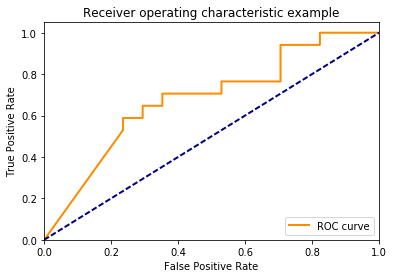

In [15]:
# Evaluate model using ROC
roc(predictions["label"], predictions["Probability"])

## Make Predictions for Specific Patients

In [30]:
# Get classifier
classifier = retrieve_model(TABLE_CLASSIFIERS, connection_string, FASTTREE_MODEL_NAME)

Rows Read: 1, Total Rows Processed: 1, Total Chunk Time: 0.025 seconds 


In [28]:
# Specify patient to make prediction for
PatientIndex = 9

In [29]:
# Select patient data
query = "SELECT TOP(1) * FROM {} AS t1 INNER JOIN {} AS t2 ON t1.patient_id = t2.patient_id WHERE t2.idx = {}".format(TABLE_FEATURES, TABLE_PATIENTS, PatientIndex)
print(query)
patient_sql = RxSqlServerData(sql_query=query, connection_string=connection_string)

SELECT TOP(1) * FROM dbo.features AS t1 INNER JOIN dbo.patients AS t2 ON t1.patient_id = t2.patient_id WHERE t2.idx = 47


In [31]:
# Make Prediction on a single patient
predictions = ml_predict(classifier, data=patient_sql, extra_vars_to_write=["label", "patient_id"])

print("The probability of cancer for patient {} with patient_id {} is {}%".format(PatientIndex, predictions["patient_id"].iloc[0], predictions["Probability"].iloc[0]*100))
if predictions["label"].iloc[0] == 0:
    print("Ground Truth: This patient does not have cancer")
else:
    print("Ground Truth: This patient does have cancer")

Beginning read starting with row: 1
Rows Read: 1, Read Time: 0.059, Transform Time: 0
Beginning read starting with row: 1
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.4769393
Finished writing 1 rows.
Writing completed.
The probability of cancer for patient 47 with patient_id 04fca9fbec0b803326488ade96897f6e is 4.203895392974451e-43%
Ground Truth: This patient does not have cancer
